In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nxaa
import sys
import random
import itertools
import time
from networkx.algorithms.approximation import dominating_set

# Alipour Approximation Ratio Test
In this notebook, I'm going to test whether the approximation ratio described in Alipour ([2019](https://doi.org/10.48550/arXiv.2012.04883)) actually holds. The ratios are described in the following sentence: "We prove that the approximation factor of this algorithm in planar triangle free graphs is 16 and 32 for MTDS problem and MDS problem, respectively."

This thus means that we should expect dominating sets that are up to 32 times larger than the minimum dominating set. I'm assuming that this worst case is unlikely to happen, but luckily this algorithm has a runtime bounded by O(m*n^2) in the naively centralised case as implemented below. The naive algorithm for the exact minimum dominating set has a runtime of O(2^n) which is considerably worse with large n.

Given the above runtimes, I expect the following procedure to be feasible:
1. Create random planar triangle free graphs for testing
2. Run the exact minimum dominating set algorithm on this graph once and save the result.
3. (Optionally) run the networkx minimum dominating set approximation algorithm as a sanity check.
4. Run the Alipour algorithm many times and collect the size of the largest returned MDS.
5. Compare the sizes of the MDSs that the different procedures return (exact, networkx, alipour)

In [2]:
def alipour(G, m):
    """
    This code implements the alipour algorithm as described in the paper https://doi.org/10.48550/arXiv.2012.04883
    The algorithm is implemented on a single computer instead of an actual network of nodes.
    """
    for node in G.nodes:
        G.nodes[node]['marks'] = 0
        G.nodes[node]['random_number'] = random.random()
        G.nodes[node]['weight'] = G.degree(node) + G.nodes[node]['random_number']

    for node in G.nodes:
        max_weight = max(G.nodes[n]["weight"] for n in nx.all_neighbors(G,node))
        for n in nx.all_neighbors(G,node):
            if G.nodes[n]["weight"] == max_weight: # should all max weight neurons be marked or only one of them?
                G.nodes[n]["marks"] += 1

    for _ in range(m):

        for node in G.nodes:
            G.nodes[node]['weight'] = G.nodes[node]['marks'] + G.nodes[node]['random_number']
            G.nodes[node]["marks"] = 0

        for node in G.nodes:
            max_weight = max(G.nodes[n]["weight"] for n in nx.all_neighbors(G,node))
            for n in nx.all_neighbors(G,node):
                if G.nodes[n]["weight"] == max_weight:
                    G.nodes[n]["marks"] += 1

    dset = []
    for n in G.nodes.data():
        if (n[1]['marks']>0):
            dset.append(n[0])
            
    return dset

In [3]:
def is_minimal(graph, dominatingset):
    """
    Function checking whether a given dominating set is actually the minimum dominating set.
    Warning: Excessive Runtime of at least O(2 ^ n). Explanation here: https://edu.nl/7wthn
    """
    if not nx.is_dominating_set(graph,dominatingset):
        return False
    for r in range(len(dominatingset)):
        for combination in itertools.combinations(graph.nodes, r=r):
            if nx.is_dominating_set(graph, list(combination)):
                return False
    return True

In [4]:
def find_minimal(graph):
    """
    Function returning a minimal dominating set.
    Warning: Excessive Runtime of at least O(2 ^ n). Explanation here: https://edu.nl/7wthn
    """
    for r in range(len(list(graph.nodes))):
        for combination in itertools.combinations(graph.nodes, r=r):
            if nx.is_dominating_set(graph, list(combination)):
                return list(combination)

The following code cell shows how to use the is_minimal and find_minimal functions.

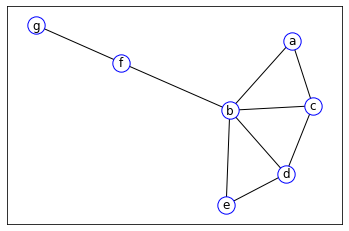

['b', 'f']
True


In [5]:
GA = nx.Graph()
GA.add_nodes_from(['a','b','c','d','e','f','g'], marks=0, random_number=0, weight=0)
GA.add_edges_from([('a', 'b'), ('a', 'c'), ('b', 'c'), ('b', 'd'), ('c', 'd'), ('d', 'e'), ('b', 'e'), ('b', 'f'), ('f', 'g')])
options = {"with_labels": True, "node_color": "white", "edgecolors": "blue"}
nx.draw_networkx(GA, **options)
plt.show()
print(find_minimal(GA))
print(is_minimal(GA, find_minimal(GA)))

## Planar Triangle Free Graphs

The following code was written to create planar triangle free graphs.

In [6]:
def is_planar(G):
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.planarity.check_planarity.html
    is_planar, certificate = nx.check_planarity(G)
    return is_planar

def is_triangle_free(G):
    # https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.cluster.triangles.html
    triangles = nx.triangles(G).values()
    nr_of_triangles = sum(triangles) / 3
    if nr_of_triangles == 0:
        return True
    else:
        return False

def create_triangle_free_planar_graph(nr_nodes, edge_probability, seed):
    G = nx.Graph()
    G.add_nodes_from(list(range(nr_nodes)))

    # Loop over all edge spaces:
    for u in G.nodes():
        for v in G.nodes():
            # Don't add an edge to a node itself.
            if u != v:

                # Add edge to compute implications.
                G.add_edge(u, v)

                # Check if adding edge yields a triangle free and planar graph.
                if is_triangle_free(G) and is_planar(G):

                    # Apply probability of creating edge
                    # TODO: Use 1-edge_probability to get bias against removing edges.
                    # TODO: Use seed to get certain list of random booleans.
                    if bool(random.getrandbits(1)):
                        G.remove_edge(u, v)
                else:
                    G.remove_edge(u, v)

    # Verify all nodes are connected to graph.
    if not nx.is_connected(G):
        G = add_connections_to_make_graph_connected(G)

    return G


def add_connections_to_make_graph_connected(G):
    # Loop over all edge spaces:
    for u in G.nodes():
        for v in G.nodes():
            # Don't add an edge to a node itself.
            if u != v:
                if not G.has_edge(u, v):

                    # Add edge to compute implications.
                    G.add_edge(u, v)

                    # Check if adding edge yields a triangle free and planar graph.
                    if is_triangle_free(G) and is_planar(G):
                        if nx.is_connected(G):
                            return G
                    else:
                        G.remove_edge(u, v)

## Experiment

In the following codeblock, an experiment is run in which it is shown how the results of the alipour algorithm compare to the results of the exact minimum dominating set and the networkx approximation in terms of size.

In [7]:
start = time.time()
for size in range(10,45,5):
    graph = create_triangle_free_planar_graph(size, 0.9, 42)
    exact_minimum_dominating_set = len(find_minimal(graph))
    networkx_approximate_dominating_set = len(dominating_set.min_weighted_dominating_set(graph))
    biggest_alipour_dominating_set = max(len(alipour(graph,50)) for _ in range(100))
    print(exact_minimum_dominating_set, networkx_approximate_dominating_set, biggest_alipour_dominating_set)
    print(f"processed graph of size {size} in {time.time()-start} seconds")
    start=time.time()

3 3 5
processed graph of size 10 in 0.3313322067260742 seconds
4 6 5
processed graph of size 15 in 0.5713369846343994 seconds
4 6 6
processed graph of size 20 in 0.8606061935424805 seconds
5 6 9
processed graph of size 25 in 1.2689919471740723 seconds
7 8 7
processed graph of size 30 in 6.890423059463501 seconds
7 9 9
processed graph of size 35 in 16.563387870788574 seconds
8 12 10
processed graph of size 40 in 192.485013961792 seconds


It's interesting to see that the runtime is horrible for graphs above 35 nodes for the exact algorithm, however in this size, we will likely not see the worst alipour results.

The large runtime tells us that we might want to look into saving the graphs and their exact minimum dominating set to make sure that we don't have to recompute them all the time. Parallelising this task could help as well, but this would only decrease the compute time by the amount of cores in a computer, while the complexity grows exponentially, so this would only help us get a few nodes further above 35. An example of this approach can be found [here](https://github.com/adiehl96/BayesianNetworks/blob/main/project2/project2.ipynb)

There is also a paper (Fomin [2004](https://sci-hub.se/10.1007/978-3-540-30559-0_21)) on algorithms to find exact minimal graphs which have complexities of the form O(c^n) whith a c that is as close as possible to 1. However their algorithm is not straightforward to read, so I don't know how quickly I could implement it.